In [1]:
!python --version 

Python 3.7.10


In [ ]:
! pip list

In [1]:
!pip freeze > requirements.txt

# CNN  
- **Xception** , ~~(ResNet50)~~ 이용
- **Transfer Learning**  
- **Fine Tuning**
___


## 캐글 Alien Predator 분류 프로젝트

캐글 https://www.kaggle.com/pmigdal/alien-vs-predator-images


Transfer learning with ResNet-50 in Keras

https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras

## 데이터 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/data-vision/day19')

In [ ]:
baseDir = 'data'

In [ ]:
trainDir = os.path.join(baseDir, 'train')
validationDir = os.path.join(baseDir, 'validation')

In [ ]:
train_alien_dir = os.path.join(trainDir, 'alien')
train_predator_dir = os.path.join(trainDir, 'predator')

In [ ]:
validation_alien_dir = os.path.join(validationDir, 'alien')
validation_predator_dir = os.path.join(validationDir, 'predator')

'/data/validation/predator'

## 사진 디렉토리 저장

In [ ]:
# 이미지 갯수 확인

In [ ]:
len( os.listdir(train_alien_dir ) ) # 트레인 데이터 -alien

347

In [ ]:
len( os.listdir(validation_alien_dir ) ) # 검증 데이터 -alien

100

In [ ]:
train_alien_listdir = os.listdir(train_alien_dir )
train_predator_listdir = os.listdir(train_predator_dir )

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

## 사진 보기

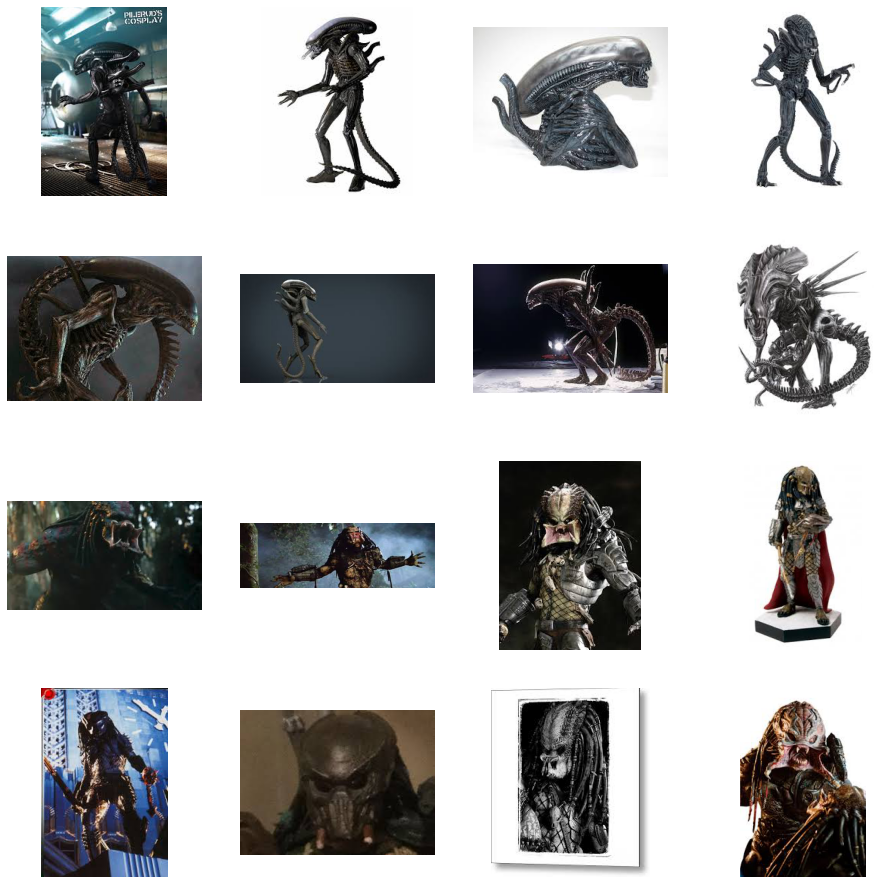

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_alien_pix = [os.path.join(train_alien_dir, fname) 
                for fname in train_alien_listdir[ pic_index-8:pic_index] 
               ]

next_predator_pix = [os.path.join(train_predator_dir, fname) 
                for fname in train_predator_listdir[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_alien_pix + next_predator_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## resnet-50 가져오기 BASE Mdel

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 트레인용 데이터 이미지 증강

In [ ]:
train_augm = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range=[0.7, 1.7],
    horizontal_flip=True 
    # shear_range = 0.1,
    # zoom_range = 0.1, 
    
    # vertical_flip=True,
    # fill_mode='nearest'
)

train_generator = train_augm.flow_from_directory (
    trainDir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'

)

Found 694 images belonging to 2 classes.


In [ ]:
# 테스트용 데이터 이미지 증강

In [ ]:
validation_augm = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range=[0.7, 1.7],
    horizontal_flip=True 
    # shear_range = 0.1,
    # zoom_range = 0.1, 
    # horizontal_flip=True, 
    # vertical_flip=True,
    # fill_mode='nearest'
)

validation_generator = validation_augm.flow_from_directory (
    validationDir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 200 images belonging to 2 classes.


## Base 모델 만들기

In [ ]:
from tensorflow.keras.applications.xception import Xception

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
# ResNet50
#baseModel = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Xception
baseModel = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
#중요- 학습 X
baseModel.trainable = False

In [ ]:
#베이스 모델 확인

In [ ]:
baseModel.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Head모델 만들기

In [ ]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
baseModel.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [ ]:
 headModel = baseModel.output

In [ ]:
headModel = GlobalAveragePooling2D()(headModel)
#headModel = Dropout ((0.2) )(headModel)
#headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)


## 모델 만들기

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

## 컴파일

In [ ]:
from tensorflow.keras.optimizers import SGD

In [ ]:
#model.compile(optimizer= SGD(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 학습

In [ ]:
model_history = model.fit( train_generator, epochs=20, validation_data=validation_generator )

Epoch 1/20
22/22 [==============================] - 16s 622ms/step - loss: 0.4908 - accuracy: 0.7269 - val_loss: 0.3385 - val_accuracy: 0.8250
Epoch 2/20
22/22 [==============================] - 12s 570ms/step - loss: 0.2385 - accuracy: 0.8919 - val_loss: 0.3175 - val_accuracy: 0.8550
Epoch 3/20
22/22 [==============================] - 12s 571ms/step - loss: 0.1945 - accuracy: 0.9353 - val_loss: 0.2624 - val_accuracy: 0.8900
Epoch 4/20
22/22 [==============================] - 12s 569ms/step - loss: 0.2046 - accuracy: 0.9225 - val_loss: 0.3250 - val_accuracy: 0.8450
Epoch 5/20
22/22 [==============================] - 12s 569ms/step - loss: 0.1526 - accuracy: 0.9359 - val_loss: 0.3467 - val_accuracy: 0.8450
Epoch 6/20
22/22 [==============================] - 12s 566ms/step - loss: 0.1319 - accuracy: 0.9471 - val_loss: 0.2621 - val_accuracy: 0.8850
Epoch 7/20
22/22 [==============================] - 12s 568ms/step - loss: 0.1697 - accuracy: 0.9236 - val_loss: 0.4152 - val_accuracy: 0.8300

## 런닝커브

In [ ]:
import numpy as np


In [ ]:
import matplotlib.pyplot as plt

def learning_curve(history, epoch):
  #정확도 차트 (accuracy)
  # x축을 epoch_range로 셋팅
  epoch_range = np.arange(1, epoch +1)

  plt.figure(figsize=(16,8))
  plt.subplot(1, 2, 1)
  
  plt.plot(epoch_range, model_history.history['accuracy'])
  plt.plot(epoch_range, model_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuraycy')
  plt.legend([ 'Train', 'Val' ] )
  # plt.show() // 차트를 따로 그리려면 위의 subplot()을 제거

  # 오차 차트 (loss) 
  plt.subplot(1, 2, 2) 

  plt.plot(epoch_range, model_history.history['loss'])
  plt.plot(epoch_range, model_history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend([ 'Train', 'Val' ] )
  plt.show()

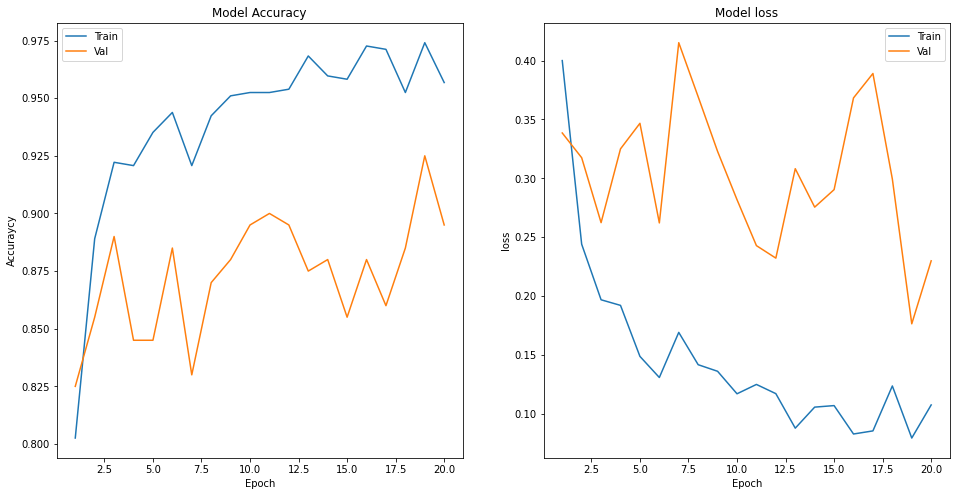

In [ ]:
learning_curve(model_history, 20)

## Fine튜닝

In [ ]:
len(baseModel.layers)

132

In [ ]:
start_layer = 125
baseModel.trainable = True

In [ ]:
for layer in baseModel.layers[ : start_layer ]:
  baseModel.trainable = False

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_history_tune = model.fit( train_generator, epochs=20, validation_data=validation_generator )

Epoch 1/20
22/22 [==============================] - 15s 617ms/step - loss: 0.1234 - accuracy: 0.9516 - val_loss: 0.3042 - val_accuracy: 0.8950
Epoch 2/20
22/22 [==============================] - 12s 567ms/step - loss: 0.0942 - accuracy: 0.9666 - val_loss: 0.3240 - val_accuracy: 0.8550
Epoch 3/20
22/22 [==============================] - 12s 564ms/step - loss: 0.0763 - accuracy: 0.9688 - val_loss: 0.3649 - val_accuracy: 0.8900
Epoch 4/20
22/22 [==============================] - 12s 566ms/step - loss: 0.0976 - accuracy: 0.9620 - val_loss: 0.2853 - val_accuracy: 0.9250
Epoch 5/20
22/22 [==============================] - 12s 561ms/step - loss: 0.0855 - accuracy: 0.9650 - val_loss: 0.2653 - val_accuracy: 0.9050
Epoch 6/20
22/22 [==============================] - 12s 560ms/step - loss: 0.0925 - accuracy: 0.9721 - val_loss: 0.2729 - val_accuracy: 0.9050
Epoch 7/20
22/22 [==============================] - 12s 559ms/step - loss: 0.0652 - accuracy: 0.9745 - val_loss: 0.2741 - val_accuracy: 0.8950

**Learning Curve Chart**  
Fine tune? 이 된 후 

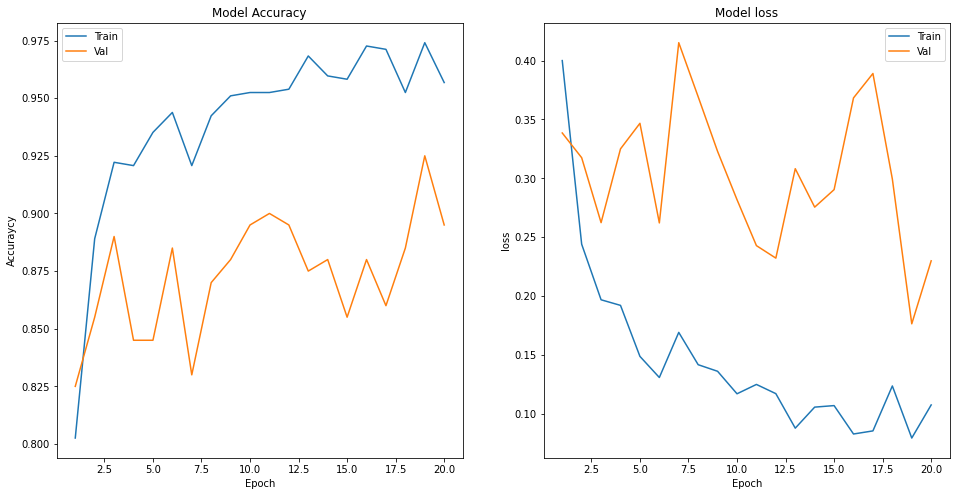

In [ ]:
learning_curve(model_history_tune, 20)

In [ ]:
# import random

In [ ]:
#  # 랜덤으로 사진 뽑기
#  validation_alien_random = os.listdir(validation_alien_dir)
#  random_alien_img = random.sample(validation_alien_random, 10)

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/drive/MyDrive/Colab Notebooks/data-vision/day19/' + fn
  img = image.load_img(path, target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a predator")
  else:
    print(fn + " is a alien")

Saving predator4.jpg to predator4 (2).jpg
Saving predator3.jpg to predator3 (2).jpg
Saving predator2.jpg to predator2 (2).jpg
Saving predator1.jpg to predator1 (2).jpg
Saving alien4.jpg to alien4 (2).jpg
Saving alien3.jpg to alien3 (2).jpg
Saving alien2.jpg to alien2 (2).jpg
Saving alien.jpg to alien (8).jpg
[1.]
predator4.jpg is a predator
[1.6797996e-12]
predator3.jpg is a alien
[8.069332e-21]
predator2.jpg is a alien
[0.97725815]
predator1.jpg is a predator
[0.9999999]
alien4.jpg is a predator
[1.]
alien3.jpg is a predator
[1.]
alien2.jpg is a predator
[1.]
alien.jpg is a predator


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/data-vision/day19


## 전체 모델 저장

In [ ]:
# 전체 저장
model.save('alien_vs_predator')

INFO:tensorflow:Assets written to: alien_vs_predator/assets


In [ ]:
# # 네트워크 구조 architecture of the network
# model_saved_json = model.to_json()
# with open('alien_vs_predator', 'w') as json_file:
#   jon_file.write(model_json)

In [ ]:
# 가중치 weight 저장
model.save_weights('alien_vs_predator_weight.h5')

In [ ]:
# 불러오기
# model.load_weights('alien_vs_predator_weight.h5')